# Import packages

In [2]:
!pip install odfpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
from statistics import mean, stdev
import pandas as pd 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, WhiteKernel, DotProduct, RBF, ConstantKernel,ExpSineSquared
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, SequentialFeatureSelector
from scipy import stats
import pickle
from sklearn.metrics import r2_score
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from scipy.stats import pearsonr, spearmanr
from shapely.geometry import  LineString
import statistics


# Load data

In [4]:
label_names  = pd.read_excel('vmaf.ods', engine = 'odf')
label_names = label_names.values.tolist()
label_names.sort()
label_names = pd.DataFrame(label_names, columns =['Video', 'P1', 'P2', 'p3'])
label_names = label_names.to_numpy()

In [5]:
label  = pd.read_excel('vmaf.ods', engine = 'odf')
label = label.values.tolist()
label.sort()
label = pd.DataFrame(label, columns =['Video', 'P1', 'P2', 'p3'])
label = label.drop(['Video'], axis=1)
label = label.to_numpy()
label_P3 = label[:,2]
label_P2 = label[:,1]
label_P1 = label[:,0]

In [6]:
features = pd.read_excel('features.ods', engine = 'odf')
features = features.fillna(features.mean())
print(features.isnull().values.any())
features = features.values.tolist()
features.sort()
features = pd.DataFrame(features, columns =['Videos', 'Mean_corr', 'Std_corr', 'Mean_cont', 'Std_cont', 'Mean_eng', 'Std_eng', 'Mean_hom', 'Std_hom', 'Mean_entr',
                                      'Std_entr', 'TC_mean_mean', 'TC_mean_std', 'TC_std_mean', 'TC_std_std', 'TC_mean_skew', 'TC_std_skew','TC_mean_kurtosis','TC_std_kurtosis',
                                      'TC_mean_entr', 'TC_std_entr', 'NCC_mean', 'NCC_std', 'colorfulness_mean', 'colorfulness_std', 'Noise_mean', 'Noise_std',  'SI_avg', 'TI_avg', 'SI_std', 'TI_std'])
features = features.drop(['Videos'], axis=1)

False


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


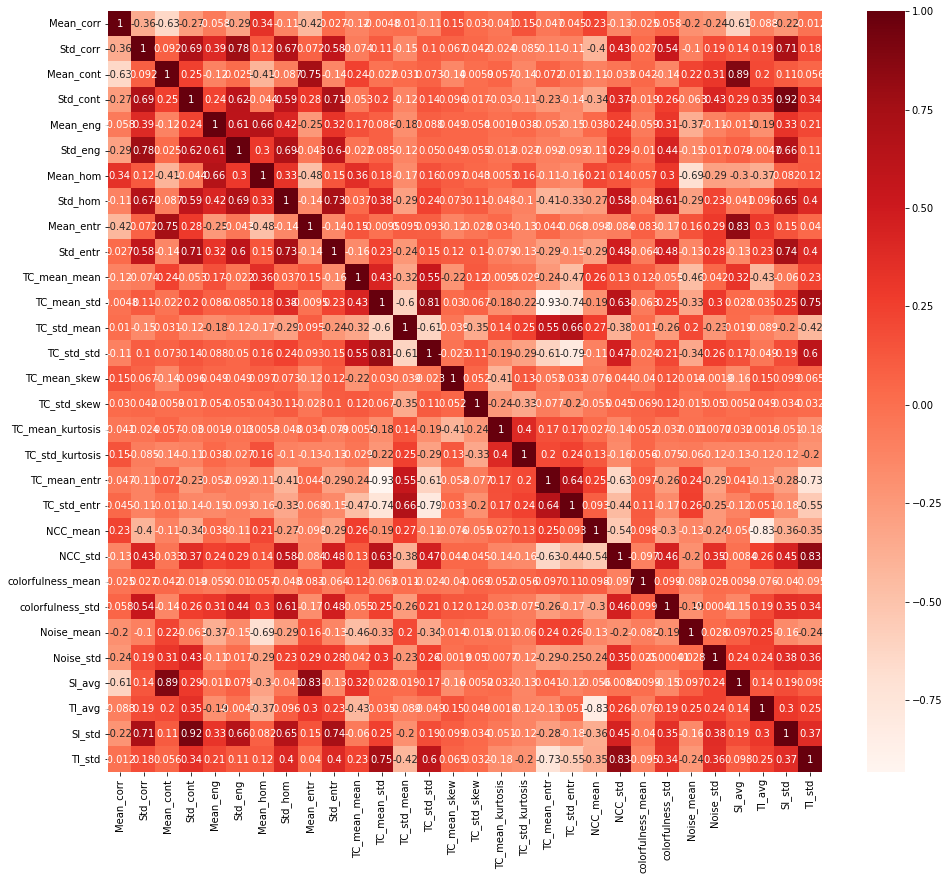

In [7]:
plt.figure(figsize=(16,14))
cor = features.corr()
fig  = sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()


# Data pre-processing

In [7]:
features_P2_full = np.zeros((196,31))
features_P3_full = np.zeros((196,30))
features_P1_full = np.zeros((196,32))
label_P3 = label_P3.reshape((196,1))
label_P2 = label_P2.reshape((196,1))
label_P1 = label_P1.reshape((196,1))
features_np = features.to_numpy()

In [8]:
features_P2_full[:,0:30]=features_np
features_P2_full[:,30:31] = label_P3
features_P1_full[:,0:30]=features_np
features_P1_full[:,30:31] = label_P3
features_P1_full[:,31:32] = label_P2
features_P3_full[:,0:30]=features_np

In [9]:
label_P3 = label_P3.reshape((196))
label_P2 = label_P2.reshape((196))
label_P1 = label_P1.reshape((196))

# Data normalization (optionnel for tree-based models)

In [13]:
min_label3 = label_P3.min()
k_p3 = label_P3.max() - label_P3.min()
min_label2 = label_P2.min()
k_p2 = label_P2.max() - label_P2.min()
min_label1 = label_P1.min()
k_p1 = label_P1.max() - label_P1.min()

In [ ]:
label_P3 = (label_P3 - label_P3.min()) / (label_P3.max() - label_P3.min())
label_P2 = (label_P2 - label_P2.min()) / (label_P2.max() - label_P2.min())
label_P1 = (label_P1 - label_P1.min()) / (label_P1.max() - label_P1.min())

Text(0.5, 1.0, 'P1')

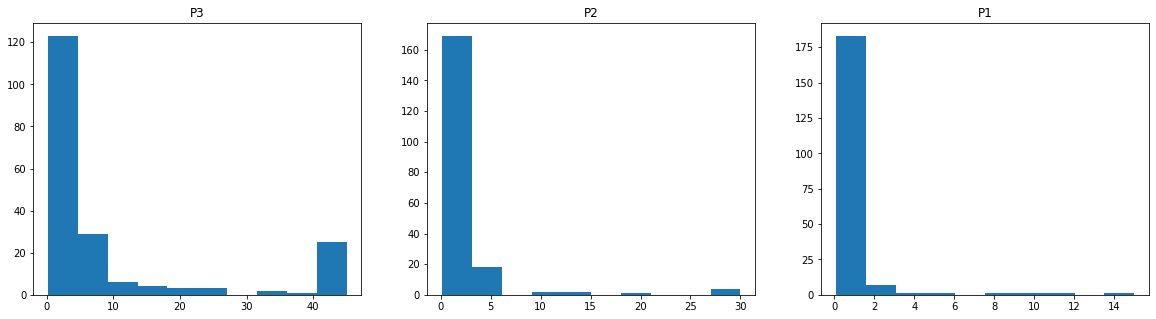

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.hist(label_P3)
plt.title("P3")
plt.subplot(1, 3, 2)
plt.hist(label_P2)
plt.title("P2")
plt.subplot(1, 3, 3)
plt.hist(label_P1)
plt.title("P1")


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'P1')

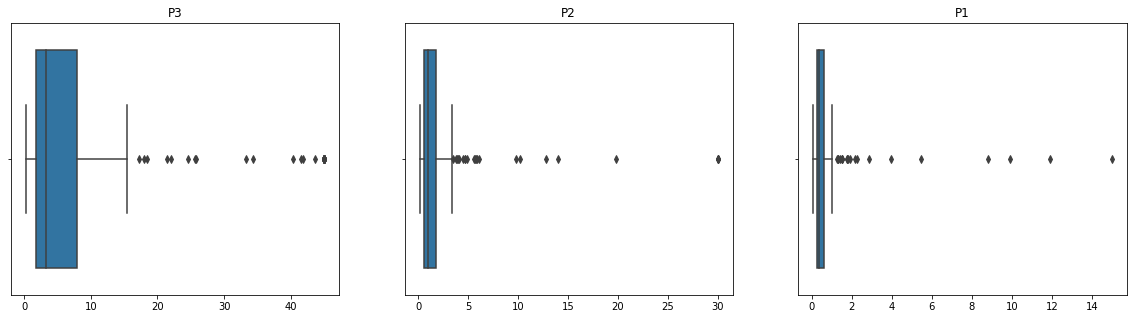

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
sns.boxplot(label_P3)
plt.title("P3")
plt.subplot(1, 3, 2)
sns.boxplot(label_P2)
plt.title("P2")
plt.subplot(1, 3, 3)
sns.boxplot(label_P1)
plt.title("P1")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 1.0, 'P1')

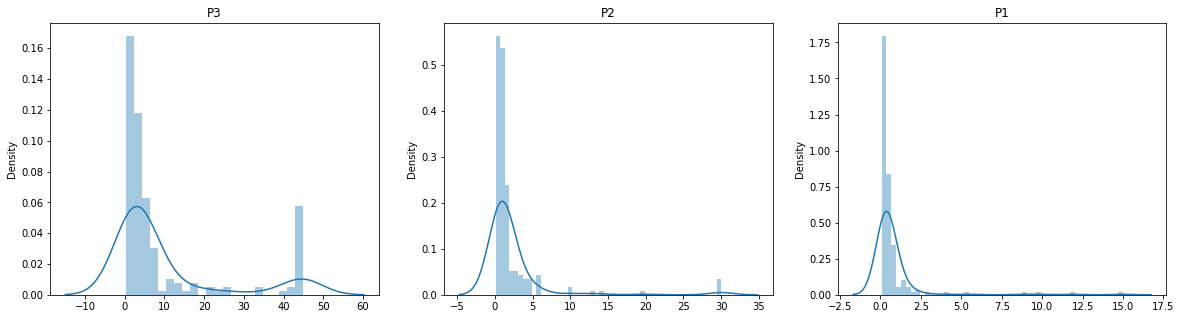

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
sns.distplot(label_P3)
plt.title("P3")
plt.subplot(1, 3, 2)
sns.distplot(label_P2)
plt.title("P2")
plt.subplot(1, 3, 3)
sns.distplot(label_P1)
plt.title("P1")

# Features selections

In [ ]:
for i in range(1,31):
  rfe = RFE(estimator=ExtraTreesRegressor(n_estimators=100, random_state=0), n_features_to_select=i)
  rfe.fit(features_P3_full, label_P3)
  X = rfe.transform(features_P3_full)
  X = rfe.transform(features_P3_full)
  X_train, X_test, y_train, y_test = train_test_split(X, label_P3, test_size=0.2 , random_state=7)
  scaler = StandardScaler().fit(X_train)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)
  m = ExtraTreesRegressor(n_estimators=100,  random_state=0).fit(X_train, y_train)
  print(m.score(X_test, y_test))

In [10]:
rfe = RFE(estimator=ExtraTreesRegressor(1000,  random_state=0), n_features_to_select=9)
rfe.fit(features_P3_full, label_P3)
X3 = rfe.transform(features_P3_full)
rfe = RFE(estimator=ExtraTreesRegressor(1000,  random_state=0), n_features_to_select=5)
rfe.fit(features_P2_full, label_P2)
X2 = rfe.transform(features_P2_full)
rfe = RFE(estimator=ExtraTreesRegressor(1000,  random_state=0), n_features_to_select=9)
rfe.fit(features_P1_full, label_P1)
X1 = rfe.transform(features_P1_full)

In [11]:
trans = StandardScaler()
X2 = trans.fit_transform(X2)
trans = StandardScaler()
X1 = trans.fit_transform(X1)
trans = StandardScaler()
X3 = trans.fit_transform(X3)

# ExtraTrees

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X3, label_P3, test_size=0.2, random_state=28)
m = ExtraTreesRegressor(n_estimators=1000,  random_state=0).fit(X_train, y_train)
y_pred_P3 = m.predict(X_test)
y_test_P3 = y_test 
#y_pred_P3 = y_pred_P3 * k_p3 + min_label3

In [13]:
print(m.score(X_test, y_test))

0.7283572035707221


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X2, label_P2, test_size=0.2, random_state=28)
m = ExtraTreesRegressor(n_estimators=1000,  random_state=0).fit(X_train, y_train)
y_pred_P2 = m.predict(X_test)
y_test_P2 = y_test 


In [57]:
print(m.score(X_test, y_test))

0.6253082011605844


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X1, label_P1, test_size=0.2, random_state=28)
m = ExtraTreesRegressor(n_estimators=1000,  random_state=0).fit(X_train, y_train)
y_pred_P1 = m.predict(X_test)
y_test_P1 = y_test 


In [55]:
print(m.score(X_test, y_test))

0.701292359124606


# XGBoost

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X3, label_P3, test_size=0.2, random_state=28)
m = XGBRegressor(max_depth=3, n_estimators= 1000, colsample_bylevel = 0.5,learning_rate = 0.01).fit(X_train, y_train)
y_pred_P3 = m.predict(X_test)
y_test_P3 = y_test 
#y_pred_P3 = y_pred_P3 * k_p3 + min_label3

[09:13:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [61]:
print(r2_score(y_test_P3,y_pred_P3 ))
print(spearmanr(y_test_P3,y_pred_P3)[0])
print(pearsonr(y_test_P3,y_pred_P3)[0])

0.6046333223799514
0.59142417285033
0.7775994142069366


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X2, label_P2, test_size=0.2, random_state=28)
m = XGBRegressor(max_depth=3, n_estimators= 1000, colsample_bylevel = 0.5,learning_rate = 0.01).fit(X_train, y_train)
y_pred_P2 = m.predict(X_test)
y_test_P2 = y_test 


[09:13:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [63]:
print(r2_score(y_test_P2,y_pred_P2 ))
print(spearmanr(y_test_P2,y_pred_P2)[0])
print(pearsonr(y_test_P2,y_pred_P2)[0])

0.27835563480785874
0.75422138836773
0.6447271667615033


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X1, label_P1, test_size=0.2, random_state=28)
m = XGBRegressor(max_depth=3, n_estimators= 1000, colsample_bylevel = 0.5,learning_rate = 0.01).fit(X_train, y_train)
y_pred_P1 = m.predict(X_test)
y_test_P1 = y_test 


[09:14:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [65]:
print(r2_score(y_test_P1,y_pred_P1 ))
print(spearmanr(y_test_P1,y_pred_P1)[0])
print(pearsonr(y_test_P1,y_pred_P1)[0])

0.6049909325224294
0.7266076783205297
0.85089033371382


# RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X3, label_P3, test_size=0.2, random_state=28)
m = RandomForestRegressor(n_estimators=1000, random_state=0).fit(X_train, y_train)
y_pred_P3 = m.predict(X_test)
y_test_P3 = y_test 
#y_pred_P3 = y_pred_P3 * k_p3 + min_label3

In [80]:
print(r2_score(y_test_P3,y_pred_P3 ))
print(spearmanr(y_test_P3,y_pred_P3)[0])
print(pearsonr(y_test_P3,y_pred_P3)[0])

0.635749775965534
0.5788206678945501
0.8008261113239663


In [81]:
X_train, X_test, y_train, y_test = train_test_split(X2, label_P2, test_size=0.2, random_state=28)
m = RandomForestRegressor(n_estimators=1000, random_state=0).fit(X_train, y_train)
y_pred_P2 = m.predict(X_test)
y_test_P2 = y_test 


In [82]:
print(r2_score(y_test_P2,y_pred_P2 ))
print(spearmanr(y_test_P2,y_pred_P2)[0])
print(pearsonr(y_test_P2,y_pred_P2)[0])

0.3863251461035955
0.7619136960600377
0.684933031569393


In [83]:
X_train, X_test, y_train, y_test = train_test_split(X1, label_P1, test_size=0.2, random_state=28)
m = RandomForestRegressor(n_estimators=1000, random_state=0).fit(X_train, y_train)
y_pred_P1 = m.predict(X_test)
y_test_P1 = y_test 


In [84]:
print(r2_score(y_test_P1,y_pred_P1 ))
print(spearmanr(y_test_P1,y_pred_P1)[0])
print(pearsonr(y_test_P1,y_pred_P1)[0])

0.6140150943246335
0.7430573993691835
0.8295455208204539


# Accuracy

In [103]:
from sklearn.metrics import accuracy_score
from  statistics import mean, stdev

In [104]:
bitrates = [ i for i in range(0,40000,300)]
for i in range(len(bitrates)):
  bitrates[i] = bitrates[i]/1000

In [105]:
def relu(x):
  if x > 0: 
    return x
  else: return 0

**Predicted_accuracy**

In [110]:
score_r2 = []
score_srocc = []
score_plcc = []
final_accuray_mean = []
final_accuray_std = []
for cm in [7]:
  X_train, X_test, y_train, y_test = train_test_split(X3, label_P3, test_size=0.2, random_state=cm)
  m = ExtraTreesRegressor(n_estimators=1000,  random_state=0).fit(X_train, y_train)
  y_pred_P3 = m.predict(X_test)
  #y_pred_P3 = y_pred_P3 * k_p3 + min_label3
  y_test_P3 = y_test 
  X_train, X_test, y_train, y_test = train_test_split(X2, label_P2, test_size=0.2, random_state=cm)
  m = ExtraTreesRegressor(n_estimators=1000,  random_state=0).fit(X_train, y_train)
  y_pred_P2 = m.predict(X_test)
  #y_pred_P2 = y_pred_P2 * k_p2 + min_label2
  y_test_P2 = y_test 
  X_train, X_test, y_train, y_test = train_test_split(X1, label_P1, test_size=0.2, random_state=cm)
  m = ExtraTreesRegressor(n_estimators=1000,  random_state=0).fit(X_train, y_train)
  y_pred_P1 = m.predict(X_test)
  #y_pred_P1 = y_pred_P1 * k_p1 + min_label1
  y_test_P1 = y_test 
  accuracy = []
  v = 0
  i = 0
  ground_truth = []
  predicted = []
  for v in range(40):
    for i in bitrates:
      if i <= relu(y_test_P1[v]):
        ground_truth.append(0)
      elif i >  y_test_P1[v] and i <= y_test_P2[v]:
        ground_truth.append(1)
      elif i >  y_test_P2[v] and i <= y_test_P3[v]:
        ground_truth.append(2)
      elif i > y_test_P3[v]:
        ground_truth.append(3)
      if i <= relu(y_pred_P1[v]):
        predicted.append(0)
      elif i >  y_pred_P1[v] and i <= y_pred_P2[v]:
        predicted.append(1)
      elif i >  y_pred_P2[v] and i <= y_pred_P3[v]:
        predicted.append(2)
      elif i > y_pred_P3[v]:
        predicted.append(3)
      else:
        print('kk')
        
    accuracy.append(accuracy_score(ground_truth, predicted))
  final_accuray_mean.append(mean(accuracy))
  final_accuray_std.append(stdev(accuracy))
  

print(mean(final_accuray_mean))
print(mean(final_accuray_std))




0.8242853252994164
0.019229401432714496


# BD-BR

In [14]:
from bj_delta import bj_delta

In [15]:
results = pd.read_excel('/content/meduim_x265.ods', engine='odf')

In [16]:
results

,Video,Codec,Resolution,Preset,QP,Bitdepth,FPS,Size (MB),Time (s),PSNR_Y,PSNR_Cb,PSNR_Cr,SSIM,VMAF
0,asian-fusion-scene5,HEVC,3840x2160,medium,15,10,60,76.264,97.5405,45.91,51.71,53.40,1.00,97.16
1,asian-fusion-scene5,HEVC,3840x2160,medium,16,10,60,67.491,89.8655,45.19,51.19,52.93,1.00,96.81
2,asian-fusion-scene5,HEVC,3840x2160,medium,17,10,60,58.814,79.4253,44.42,50.64,52.45,1.00,96.37
3,asian-fusion-scene5,HEVC,3840x2160,medium,18,10,60,50.988,77.5620,43.69,50.10,52.01,1.00,95.90
4,asian-fusion-scene5,HEVC,3840x2160,medium,19,10,60,43.661,75.0107,42.96,49.59,51.59,1.00,95.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24299,Vlog-14,HEVC,1280x720,medium,41,10,60,0.046,0.9524,31.05,37.62,36.67,0.97,33.16
24300,Vlog-14,HEVC,1280x720,medium,42,10,60,0.042,0.9866,30.59,37.53,36.53,0.96,30.70
24301,Vlog-14,HEVC,1280x720,medium,43,10,60,0.038,0.8628,30.13,37.12,36.07,0.95,28.19
24302,Vlog-14,HEVC,1280x720,medium,44,10,60,0.034,0.8979,29.54,37.14,35.98,0.95,23.70


In [17]:
def find_names(ind):
  names = []
  X_train, X_test, y_train, y_test = train_test_split(label_names, label_names, test_size=0.2, random_state=ind)
  y_test = y_test.tolist()
  for i in y_test:
    names.append(i[0])
  return names

In [18]:
def df_selection(names):
  results_test = results[(results['Video'] == names[0])]
  for i in names[1:]:
    results_test_2 = results[(results['Video'] == i)]
    results_test = pd.concat([results_test, results_test_2])
  return results_test

In [24]:
#apple
def bd_q_selection(y_test, y_pred, results_test, names):
  results_test_sd = results_test[(results_test['Resolution'] == '720x480')]
  results_test_hd = results_test[(results_test['Resolution'] == '1280x720')]
  results_test_fd = results_test[(results_test['Resolution'] == '1920x1080')]
  results_test_4k = results_test[(results_test['Resolution'] == '3840x2160')] 
  predicted_bd = []
  predicted_q = []
  true_bd = []
  true_q = []
  apple_bd = []
  apple_q = []
  y_test = y_test.tolist()
  y_pred = y_pred.tolist()
  for nm in range(len(names)):
    sd = results_test_sd[(results_test_sd['Size (MB)'] * 8 * 1.066666667 < y_pred[nm][0])& (results_test_sd['Video'] ==names[nm])]
    hd = results_test_hd[(results_test_hd['Size (MB)'] * 8 * 1.066666667 > y_pred[nm][0])& (results_test_hd['Size (MB)'] * 8 * 1.066666667 < y_pred[nm][1])&(results_test_hd['Video'] ==names[nm])]
    fd = results_test_fd[(results_test_fd['Size (MB)'] * 8 * 1.066666667 > y_pred[nm][1])& (results_test_fd['Size (MB)'] * 8 * 1.066666667 < y_pred[nm][2])&(results_test_fd['Video'] ==names[nm])]
    k = results_test_4k[(results_test_4k['Size (MB)'] * 8 * 1.066666667 > y_pred[nm][2])& (results_test_4k['Video'] ==names[nm])]
    sdd = sd.values.tolist()
    hdd = hd.values.tolist()
    fdd = fd.values.tolist()
    kd = k.values.tolist()
    temp = []
    temp2 = []
    for i in sdd:
      temp.append(i[7]* 8 * 1.066666667)
      temp2.append(i[-5])
    for i in hdd:
      temp.append(i[7]* 8 * 1.066666667)
      temp2.append(i[-5])
    for i in fdd:
      temp.append(i[7]* 8 * 1.066666667)
      temp2.append(i[-5])
    for i in kd:
      temp.append(i[7]* 8 * 1.066666667)
      temp2.append(i[-5])
    predicted_bd.append(temp)
    predicted_q.append(temp2)
    sd = results_test_sd[(results_test_sd['Size (MB)']* 8 * 1.066666667 < y_test[nm][1])& (results_test_sd['Video'] ==names[nm])]
    hd = results_test_hd[(results_test_hd['Size (MB)'] * 8 * 1.066666667 > y_test[nm][0])& (results_test_hd['Size (MB)'] * 8 * 1.066666667 < y_test[nm][1])&(results_test_hd['Video'] ==names[nm])]
    fd = results_test_fd[(results_test_fd['Size (MB)'] * 8 * 1.066666667 > y_test[nm][1])& (results_test_fd['Size (MB)'] * 8 * 1.066666667 < y_test[nm][2])&(results_test_fd['Video'] ==names[nm])]
    k = results_test_4k[(results_test_4k['Size (MB)'] * 8 * 1.066666667 > y_test[nm][2])& (results_test_4k['Video'] ==names[nm])]
    sdd = sd.values.tolist()
    hdd = hd.values.tolist()
    fdd = fd.values.tolist()
    kd = k.values.tolist()
    temp = []
    temp2 = []
    for i in sdd:
      temp.append(i[7]* 8 * 1.066666667)
      temp2.append(i[-5])
    for i in hdd:
      temp.append(i[7]* 8 * 1.066666667)
      temp2.append(i[-5])
    for i in fdd:
      temp.append(i[7]* 8 * 1.066666667)
      temp2.append(i[-5])
    for i in kd:
      temp.append(i[7]* 8 * 1.066666667)
      temp2.append(i[-5])
    true_bd.append(temp)
    true_q.append(temp2)
    sd = results_test_sd[(results_test_sd['Size (MB)'] * 8 * 1.066666667 < 2.4)& (results_test_sd['Video'] ==names[nm])]
    hd = results_test_hd[(results_test_hd['Size (MB)'] * 8 * 1.066666667 > 2.4)& (results_test_hd['Size (MB)'] * 8 * 1.066666667 < 5.8)&(results_test_hd['Video'] ==names[nm])]
    fd = results_test_fd[(results_test_fd['Size (MB)'] * 8 * 1.066666667 > 5.8)& (results_test_fd['Size (MB)'] * 8 * 1.066666667 < 16.8)&(results_test_fd['Video'] ==names[nm])]
    k = results_test_4k[(results_test_4k['Size (MB)'] * 8 * 1.066666667 > 16.8)& (results_test_4k['Video'] ==names[nm])]
    sdd = sd.values.tolist()
    hdd = hd.values.tolist()
    fdd = fd.values.tolist()
    kd = k.values.tolist()
    temp = []
    temp2 = []
    for i in sdd:
      temp.append(i[7]* 8 * 1.066666667)
      temp2.append(i[-5])
    for i in hdd:
      temp.append(i[7]* 8 * 1.066666667)
      temp2.append(i[-5])
    for i in fdd:
      temp.append(i[7]* 8 * 1.066666667)
      temp2.append(i[-5])
    for i in kd:
      temp.append(i[7]* 8 * 1.066666667)
      temp2.append(i[-5])
    apple_bd.append(temp)
    apple_q.append(temp2)


  return predicted_bd, predicted_q, true_bd, true_q, apple_bd, apple_q 




In [28]:
apple = []
ref = []
for cm in [10]:
  X_train, X_test, y_train, y_test = train_test_split(X3, label_P3, test_size=0.2, random_state=cm)
  m = ExtraTreesRegressor(n_estimators=1000,  random_state=0).fit(X_train, y_train) 
  y_pred_P3 = m.predict(X_test)
  #y_pred_P3 = y_pred_P3 * k_p3 + min_label3
  y_test_P3 = y_test 
  X_train, X_test, y_train, y_test = train_test_split(X2, label_P2, test_size=0.2, random_state=cm)
  m = ExtraTreesRegressor(n_estimators=1000,  random_state=0).fit(X_train, y_train) 
  y_pred_P2 = m.predict(X_test)
  #y_pred_P2 = y_pred_P2 * k_p2 + min_label2
  y_test_P2 = y_test 
  X_train, X_test, y_train, y_test = train_test_split(X1, label_P1, test_size=0.2, random_state=cm)
  m = ExtraTreesRegressor(n_estimators=1000,  random_state=0).fit(X_train, y_train) 
  y_pred_P1 = m.predict(X_test)
  #y_pred_P1 = y_pred_P1 * k_p1 + min_label1
  y_test_P1 = y_test 
  y_test_full = np.zeros((40,3))
  y_pred_full = np.zeros((40,3))
  y_test_full[:,0] = y_test_P1
  y_test_full[:,1] = y_test_P2
  y_test_full[:,2] = y_test_P3
  y_pred_full[:,0] = y_pred_P1
  y_pred_full[:,1] = y_pred_P2
  y_pred_full[:,2] = y_pred_P3
  names = find_names(cm)
  results_test = df_selection(names)
  predicted_bd, predicted_q, true_bd, true_q, apple_bd, apple_q = bd_q_selection(y_test_full, y_pred_full, results_test, names)
  temp_apple = []
  temp_ref = []
  for i in range(40):
    bd_rate1 = bj_delta(apple_bd[i], apple_q[i], predicted_bd[i], predicted_q[i], mode=1)
    bd_rate2 = bj_delta(true_bd[i], true_q[i], predicted_bd[i], predicted_q[i], mode=1)
    temp_apple.append(bd_rate1)
    temp_ref.append(bd_rate2)
  apple.append(mean(temp_apple))
  ref.append(mean(temp_ref))

In [31]:
mean(ref)

1.722061496877107

In [32]:
mean(apple)

-19.899900542848826